In [2]:
# **********************************************************************************************************************
# IMPORTING LIBRARIES
# **********************************************************************************************************************
import pandas as pd
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

#Libraries required for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib import figure
from matplotlib.colors import ListedColormap

#Library required for normalisation of data
from sklearn import preprocessing

#Libraries required for tuning parameters
from yellowbrick.cluster import KElbowVisualizer 
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

import itertools 

#Libraries required for clustering algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

import warnings
warnings.simplefilter("ignore")

from matplotlib import style
style.use('seaborn')

In [3]:
# **********************************************************************************************************************
# DATA EXPLORATION
# **********************************************************************************************************************

#Source of dataset
#P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis, "Modeling wine preferences by data mining from physicochemical properties", Decision Support Systems, vol. 47, no. 4, pp. 547-553, 2009. Available: 10.1016/j.dss.2009.05.016.

#Importing the data files and setting delimiter to ';' 
#Adding categorical variable according to the type of wine

df_red = pd.read_csv("winequality-red.csv", delimiter=";")
df_red['type']='red'

df_white = pd.read_csv("winequality-white.csv", delimiter=";")
df_white['type']='white'

df = df_red.append(df_white)

def type_to_num(i):
    if i == 'red':
        return 1
    if i == 'white':
        return 2

df['type_num'] = df['type'].apply(type_to_num)
df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality   type  type_num  
0         9.4        5    red         1  
1         9.8        5    red         1  
2         9.8        5    red         1  
3         9.8        6    red         1  
4         9.4        5    red         1  
...       ...      ...    ...       ...  
4893     11.2        6  white         2  
4894      9.6        5  white         2  
4895      9.4        6  white         2  
4896     12.8        7  white         2  
4897     11.8        6  white         2  

[6497 rows x 14 columns]

In [4]:
#Listing features 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
 13  type_num              6497 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 761.4+ KB


In [5]:
#Checking for Null values
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
type_num                0
dtype: int64

In [6]:
#Checking for Duplicate values
print('Duplicates: ' + str(df.duplicated().sum()))
df_unique = df.drop_duplicates()

Duplicates: 1177


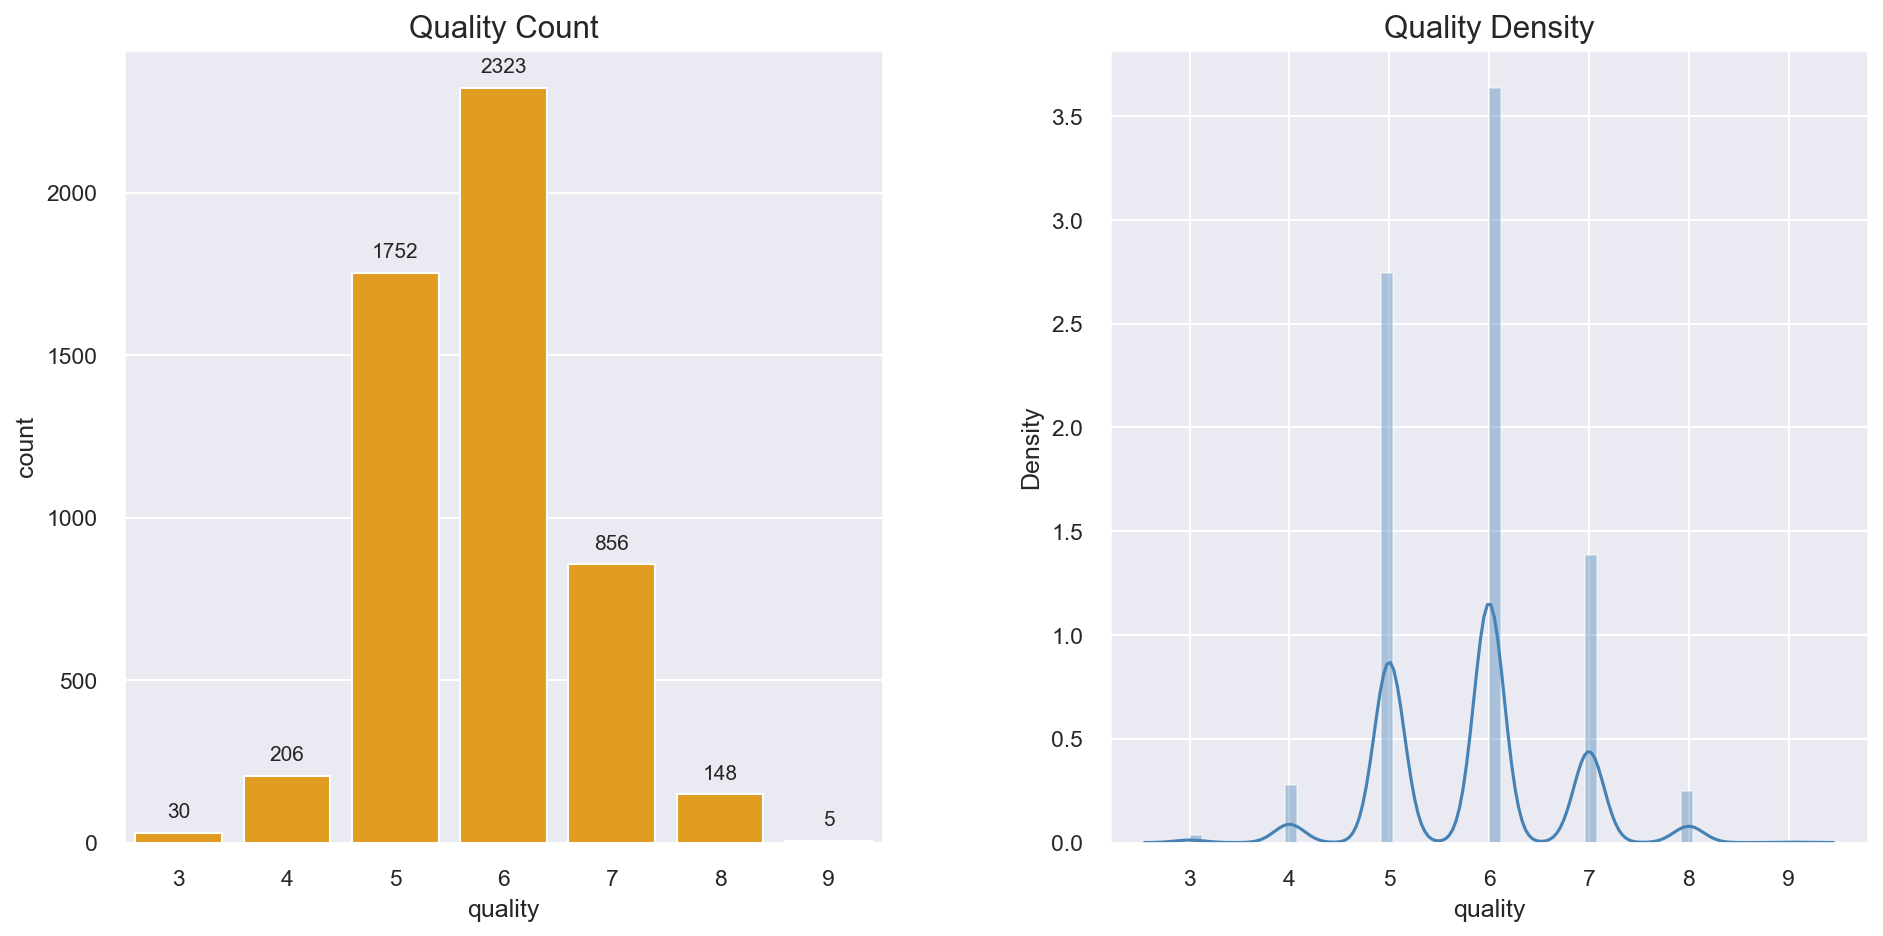

In [38]:
#Quality count 
f, axes = plt.subplots(1, 2)
f.set_size_inches(15, 7)

quality_count = sns.countplot(df_unique['quality'], color='orange', ax=axes[0])
quality_count.title.set_text('Quality Count')
quality_count.title.set_size(15)
for p in quality_count.patches:
    quality_count.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)

quality_density = sns.distplot(df['quality'], color='steelblue', ax=axes[1])
quality_density.title.set_text('Quality Density')
quality_density.title.set_size(15)

plt.subplots_adjust(wspace=0.3)
plt.show()

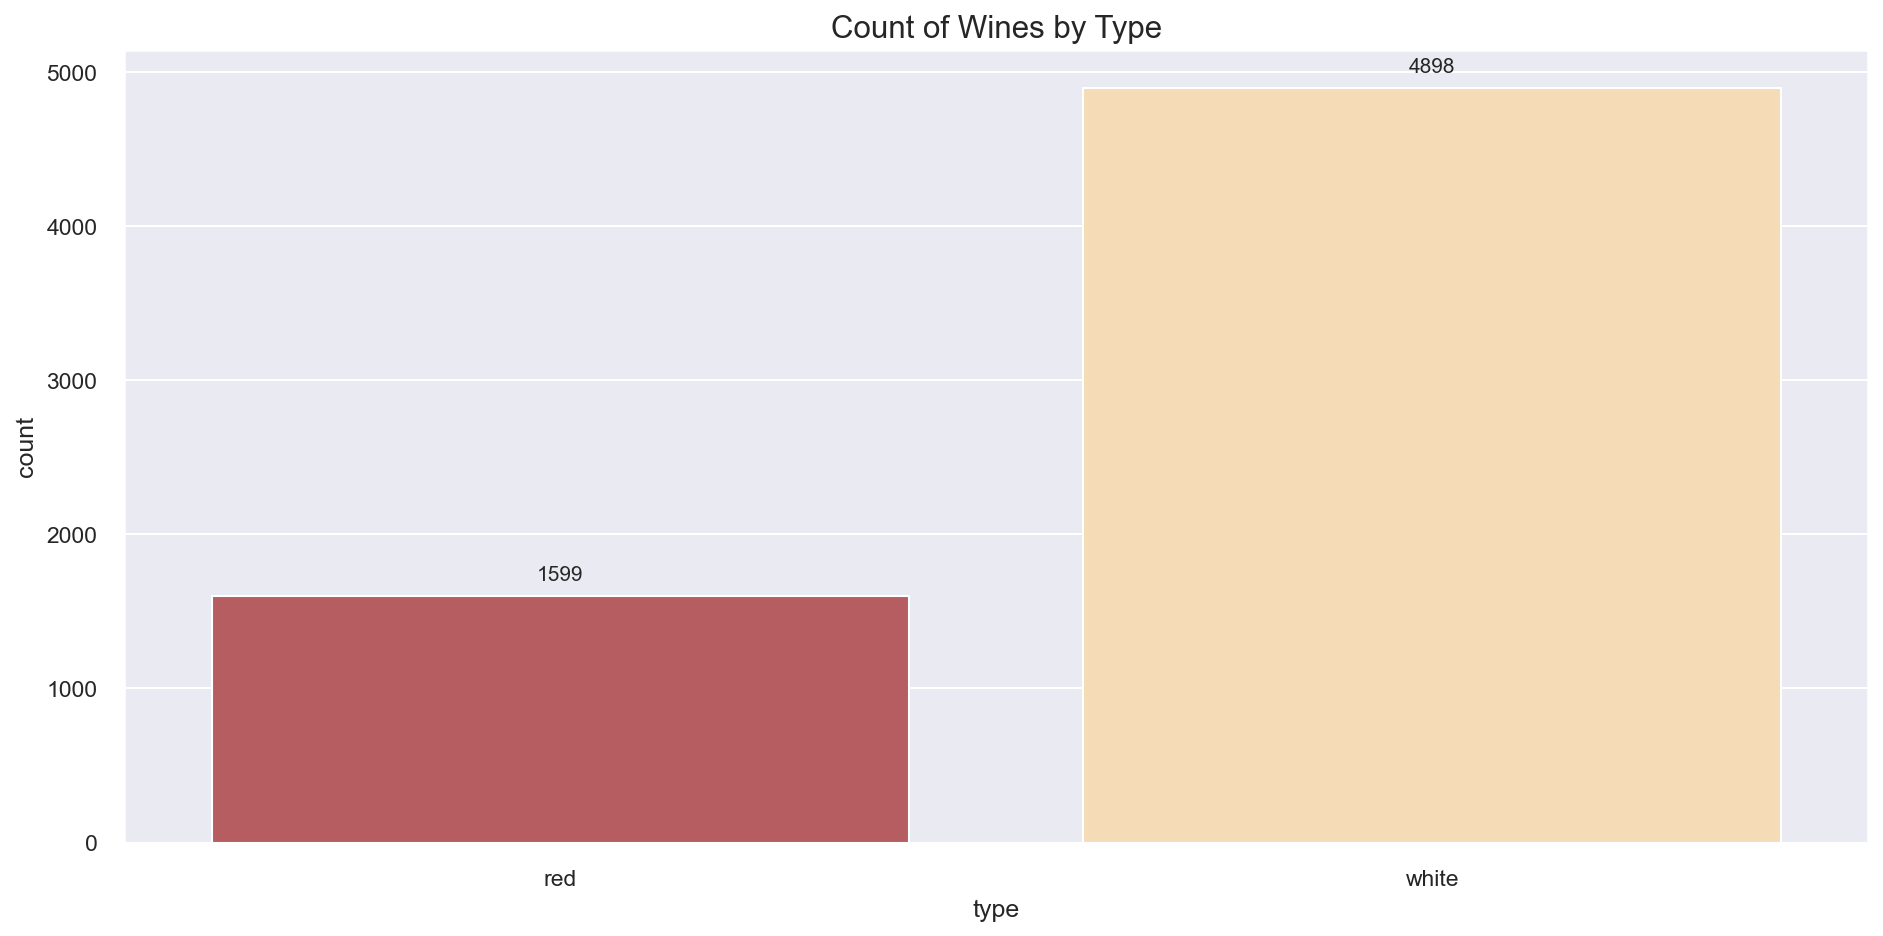

In [39]:
#Type count 
f, axes = plt.subplots(1)
f.set_size_inches(15, 7)
type_count = sns.countplot(df['type'], palette={'red':'r', 'white':'navajowhite'})
df['type'].value_counts()
for p in type_count.patches:
    type_count.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)
plt.title('Count of Wines by Type',fontsize=15)
plt.show()

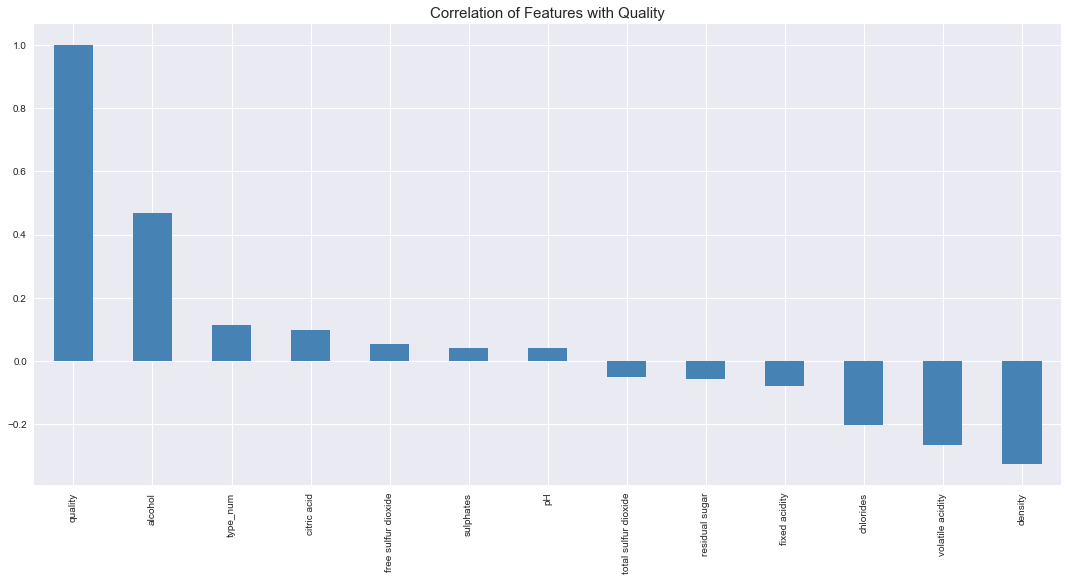

In [9]:
#Correlation of features with quality
f, axes = plt.subplots(1)
f.set_size_inches(15, 8)
correlations = df_unique.corr()['quality'].sort_values(ascending=False)
correlations.plot(kind='bar',color='steelblue')
plt.tight_layout()
plt.title('Correlation of Features with Quality',fontsize=15)
plt.show()

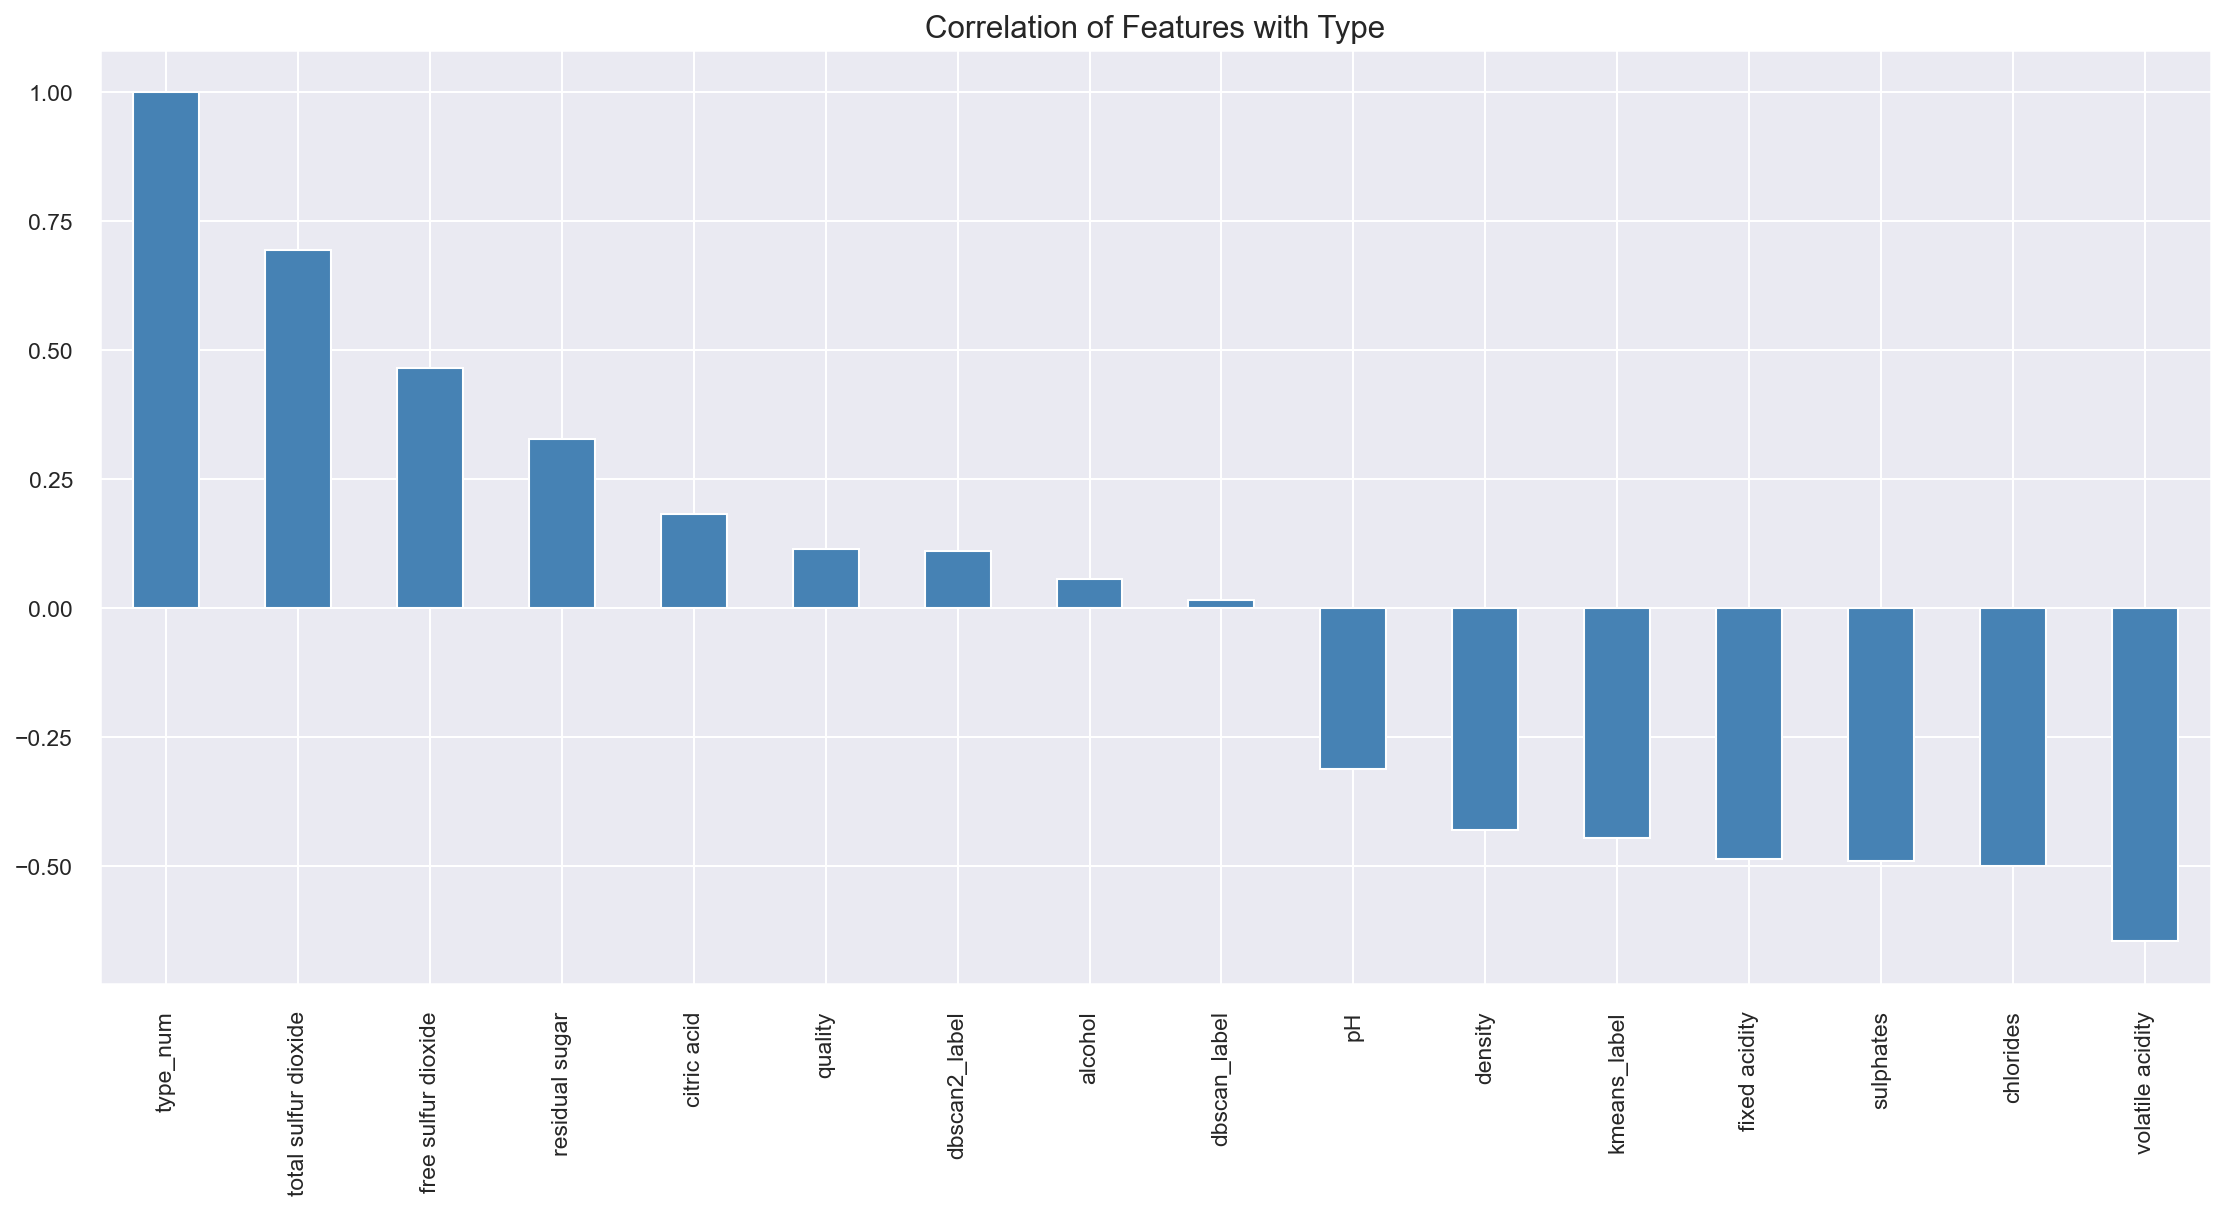

In [40]:
#Correlation of features with type
f, axes = plt.subplots(1)
f.set_size_inches(15, 8)
correlations = df_unique.corr()['type_num'].sort_values(ascending=False)
sns.set(font_scale=1)
correlations.plot(kind='bar',color='steelblue')
plt.tight_layout()
plt.title('Correlation of Features with Type',fontsize=15)
plt.show()

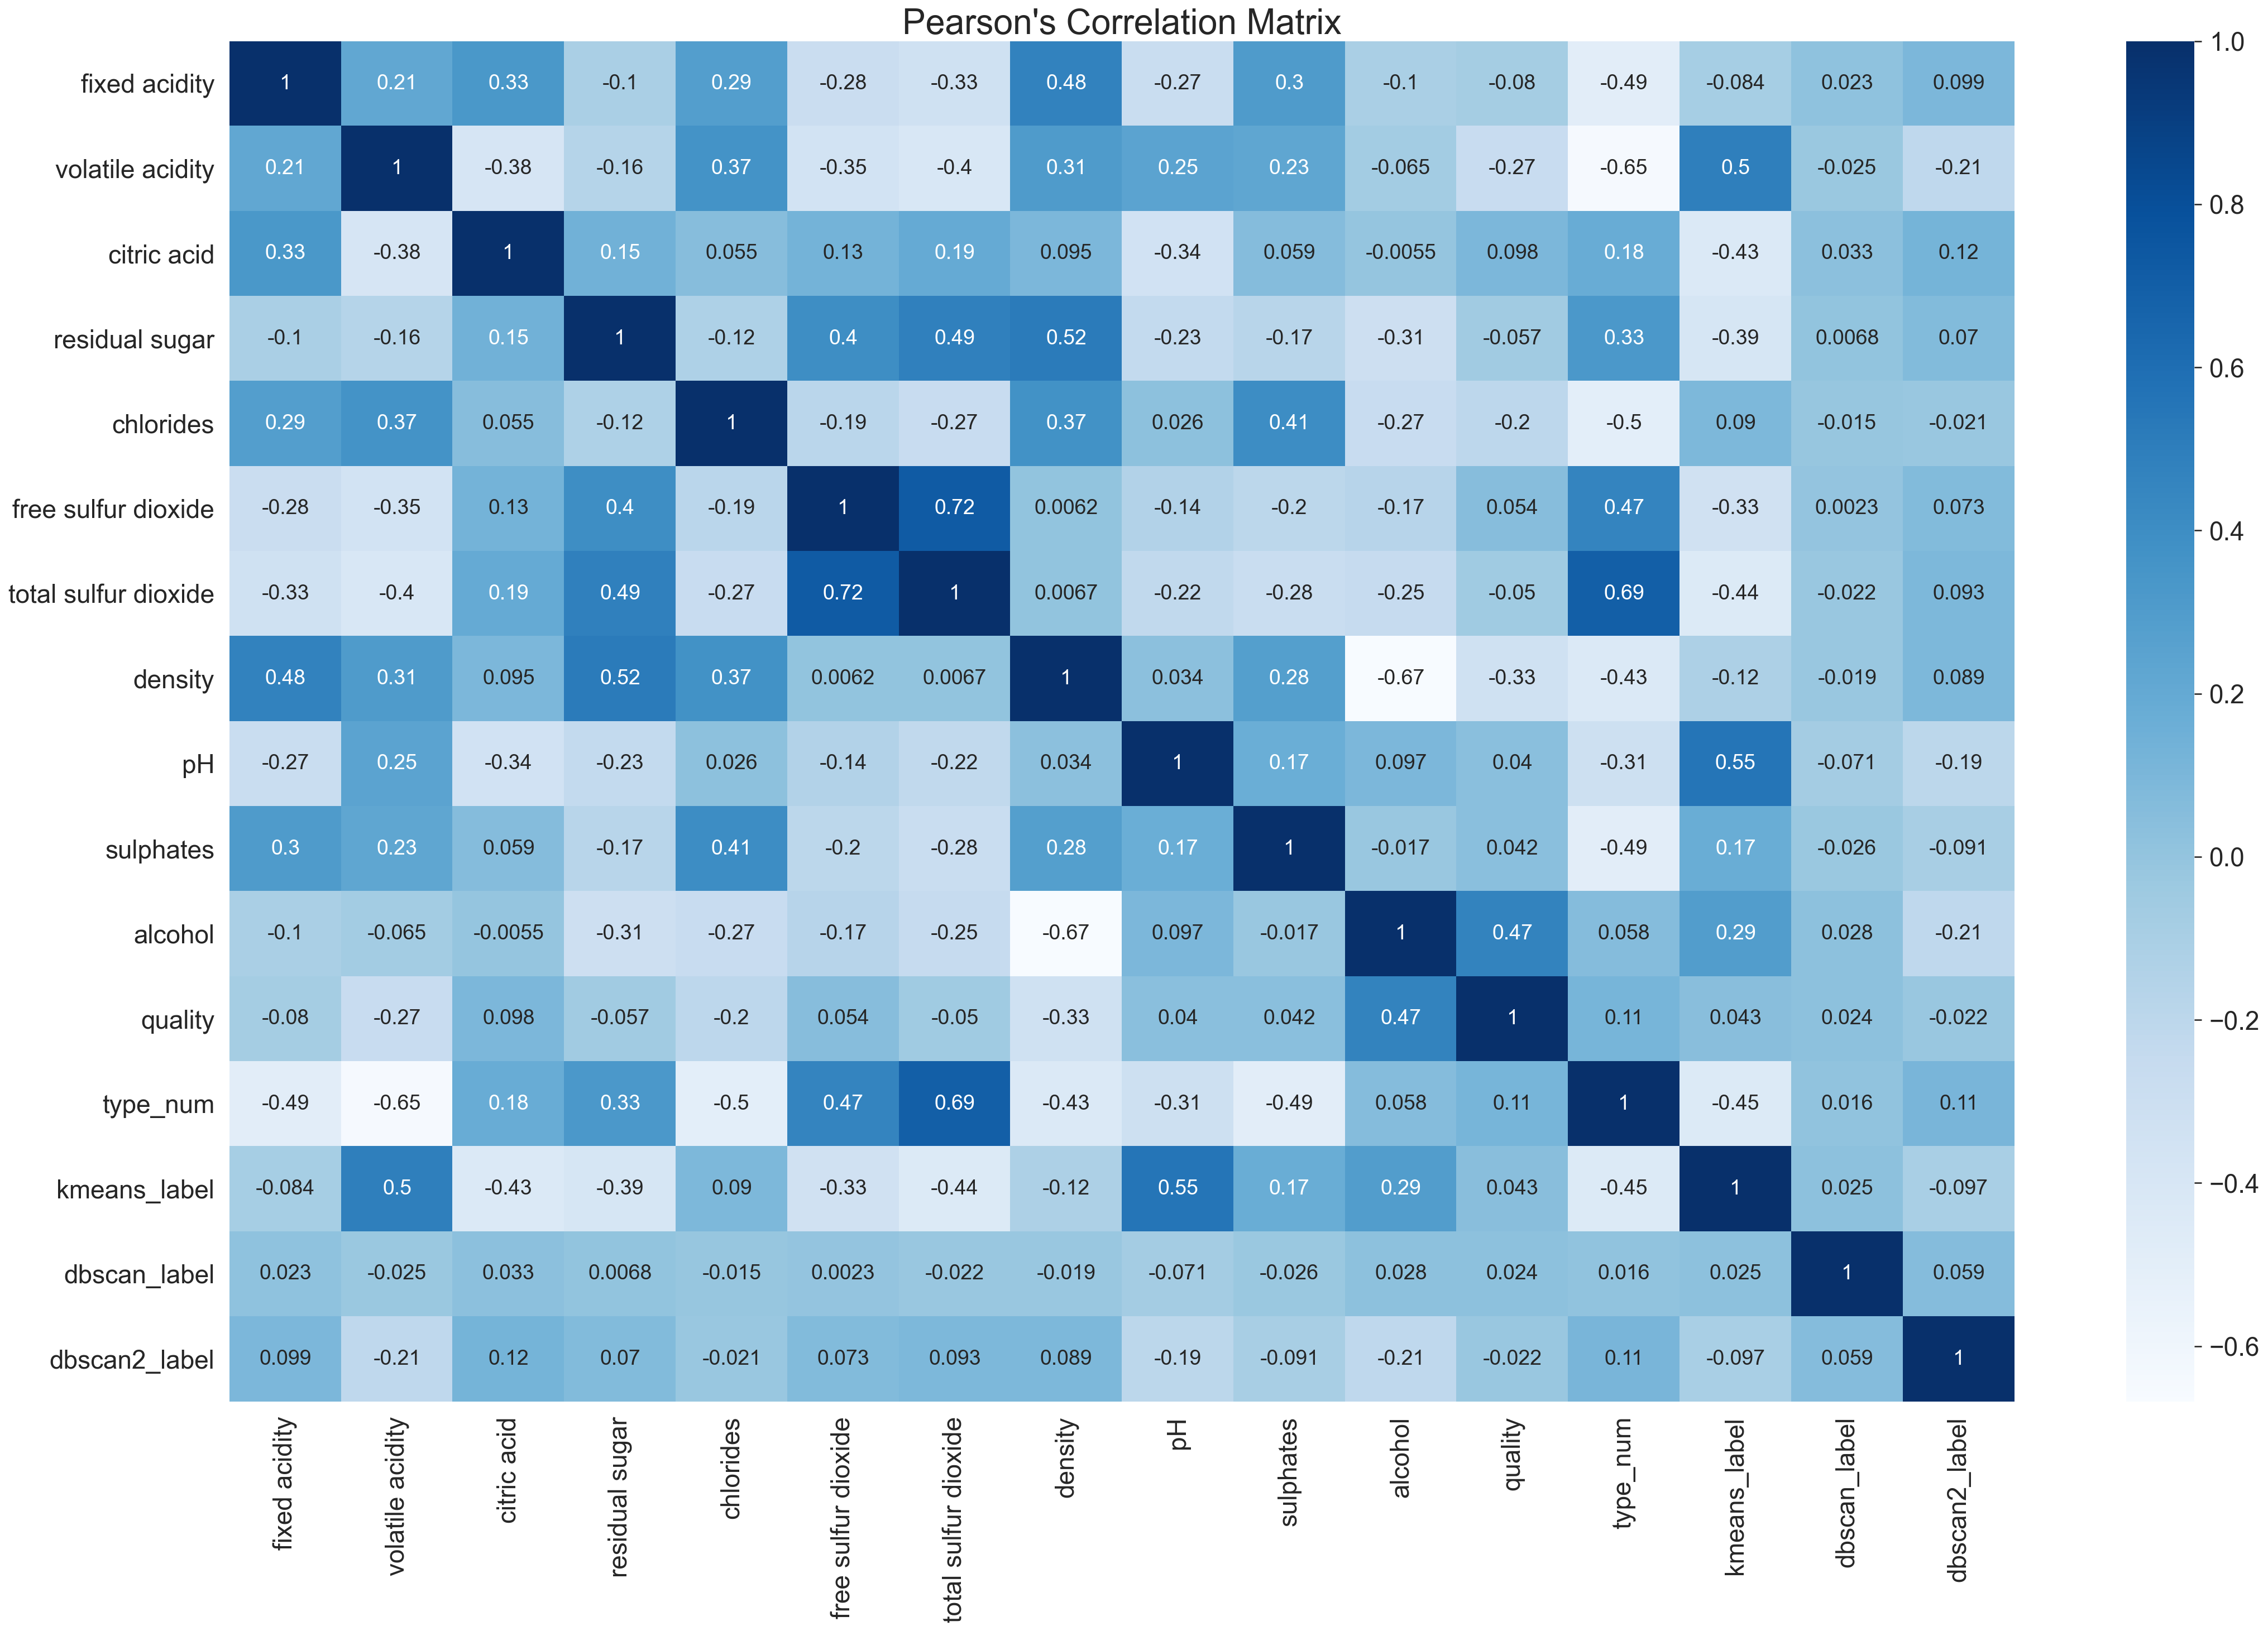

In [42]:
#Correlation Matrix
sns.heatmap(df_unique.corr(), cmap='Blues', annot=True, annot_kws={'size':18})
sns.set(rc={'figure.figsize':(30,20)})
sns.set(font_scale=2)
plt.title("Pearson's Correlation Matrix", fontsize=30) 
plt.tight_layout()
plt.show()

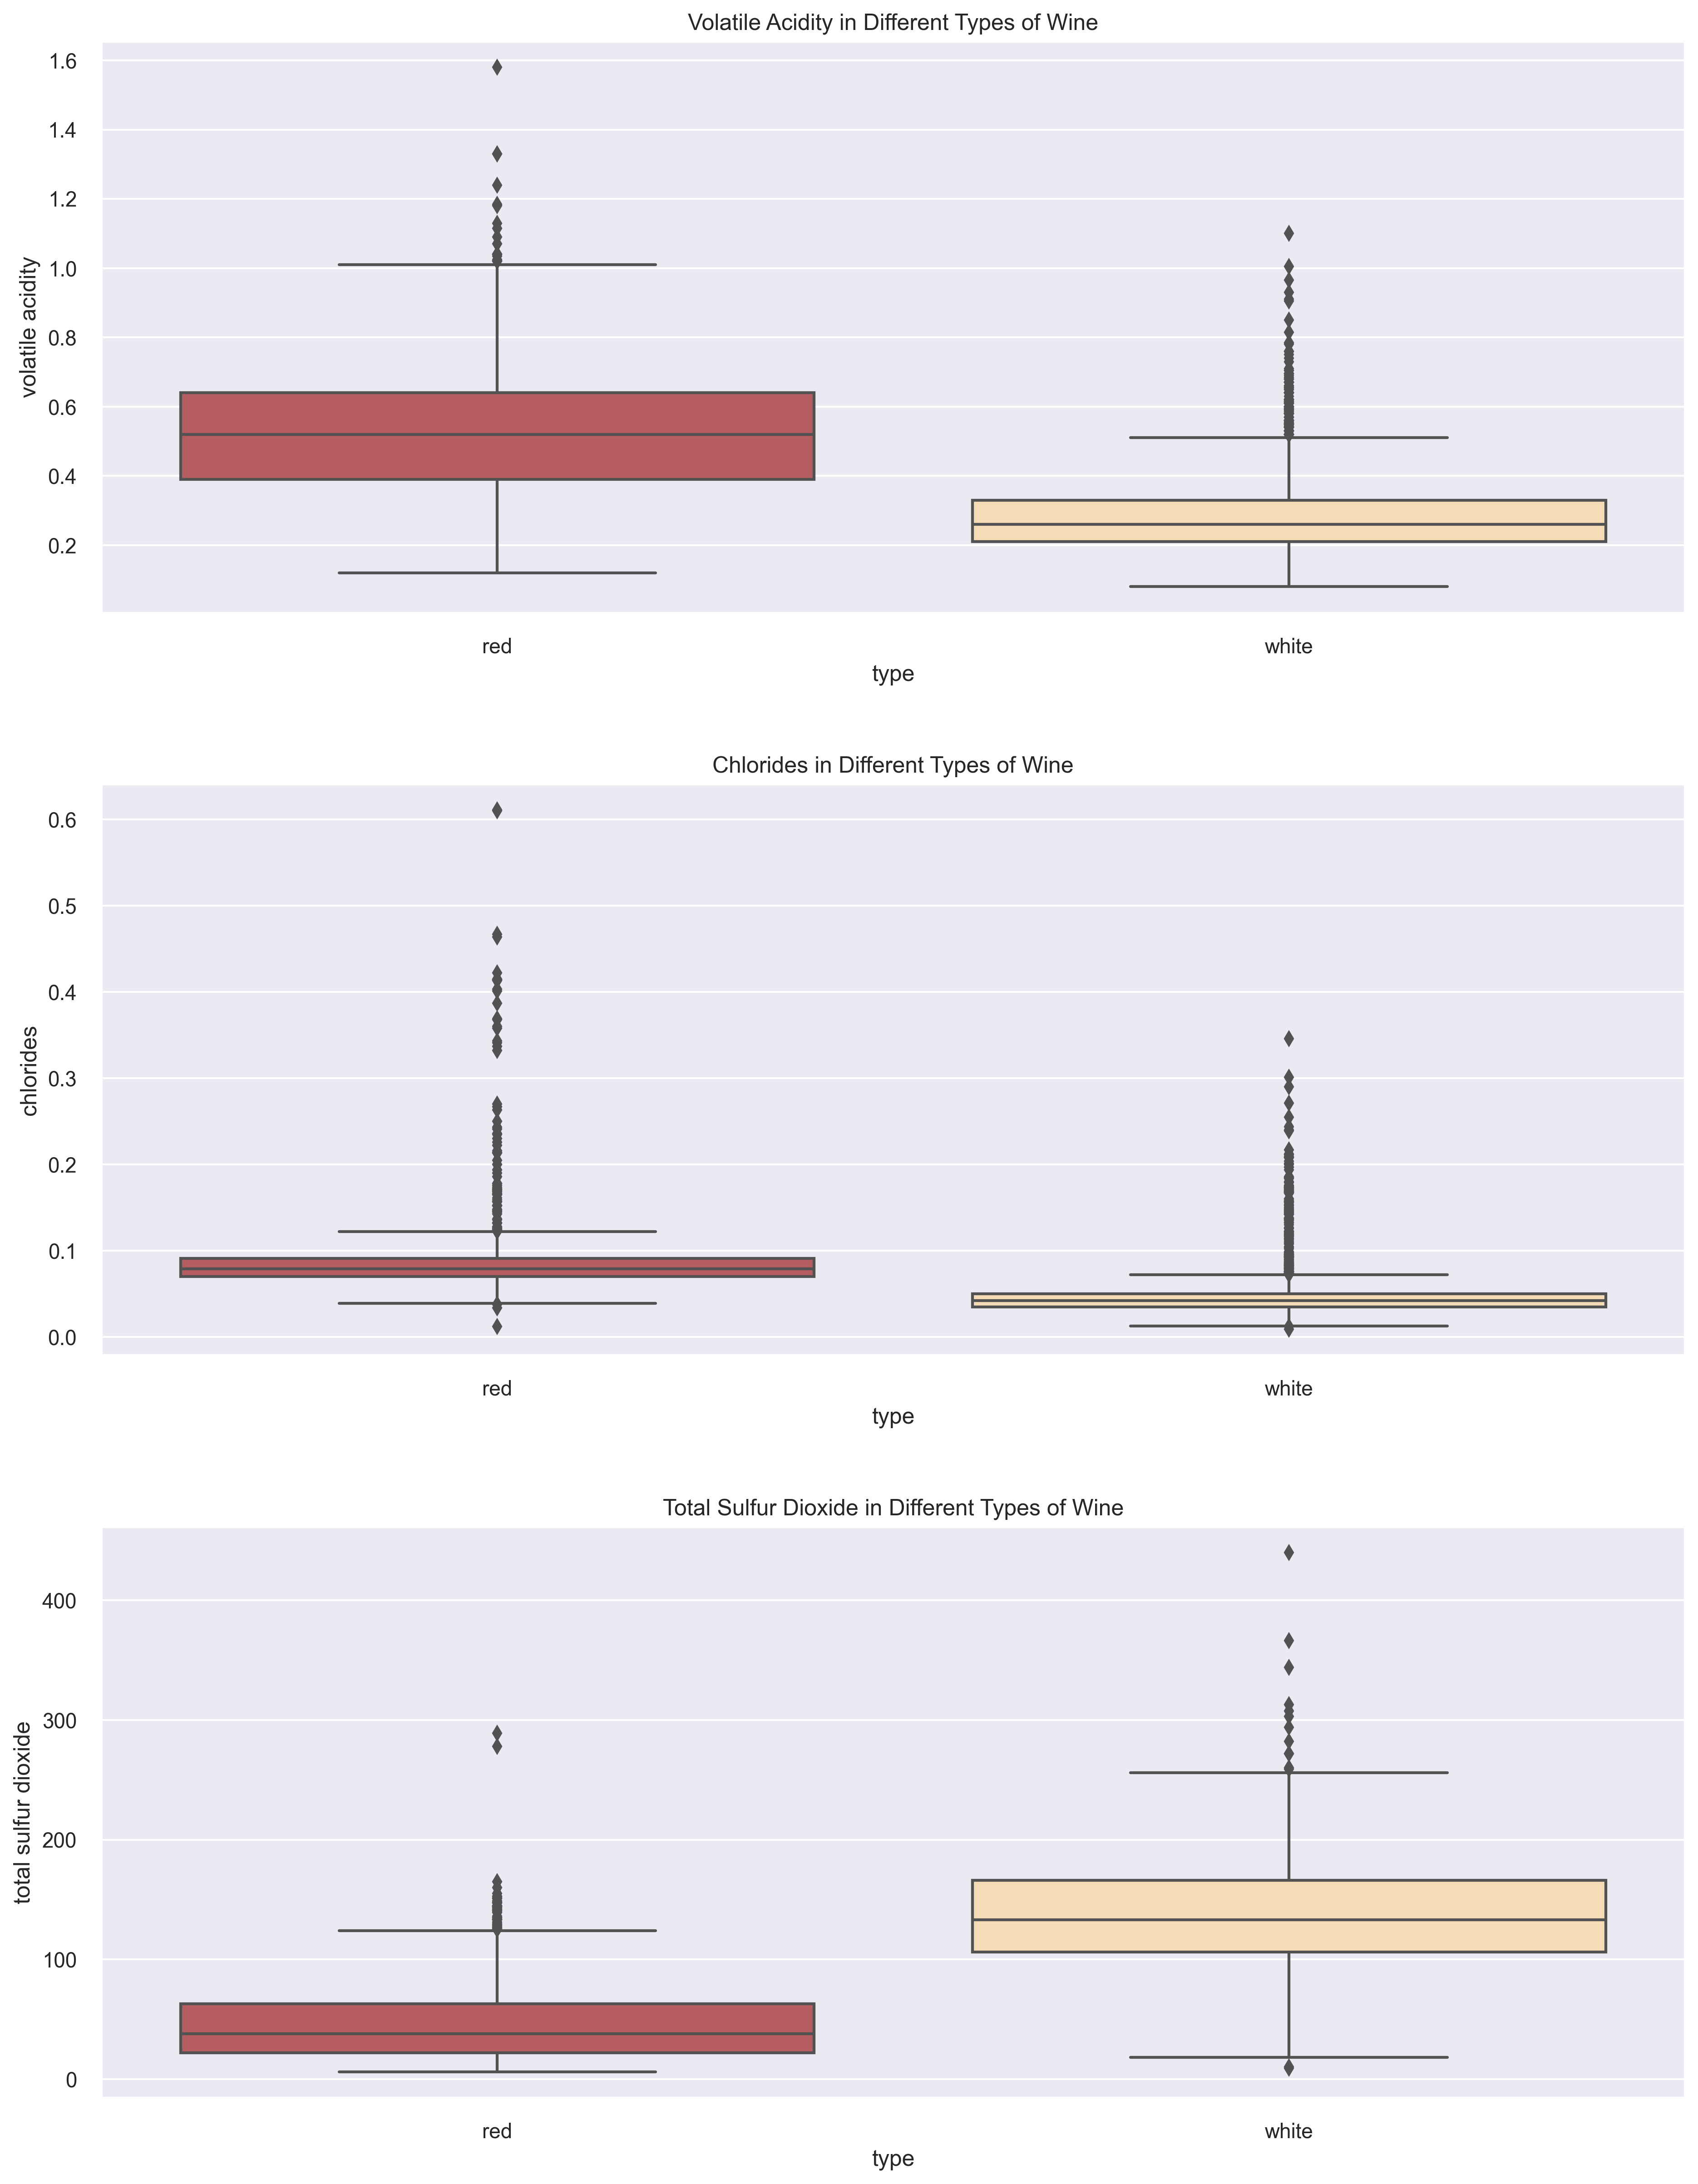

In [44]:
#Box plots for features correlated with type
f, axes = plt.subplots(ncols=1, nrows=3,dpi=300)
f.set_size_inches(15,20)
bp1=sns.boxplot(ax=axes[0],x='type',y='volatile acidity', data=df_unique, palette={'red':'r', 'white':'navajowhite'}).set(title="Volatile Acidity in Different Types of Wine")
bp2=sns.boxplot(ax=axes[1],x='type',y='chlorides', data=df_unique, palette={'red':'r', 'white':'navajowhite'}).set(title="Chlorides in Different Types of Wine")
bp3=sns.boxplot(ax=axes[2],x='type',y='total sulfur dioxide', data=df_unique, palette={'red':'r', 'white':'navajowhite'}).set(title="Total Sulfur Dioxide in Different Types of Wine")
plt.subplots_adjust(wspace=0.3, hspace=0.3)
sns.set(rc={'figure.figsize':(10,20)})
plt.show()

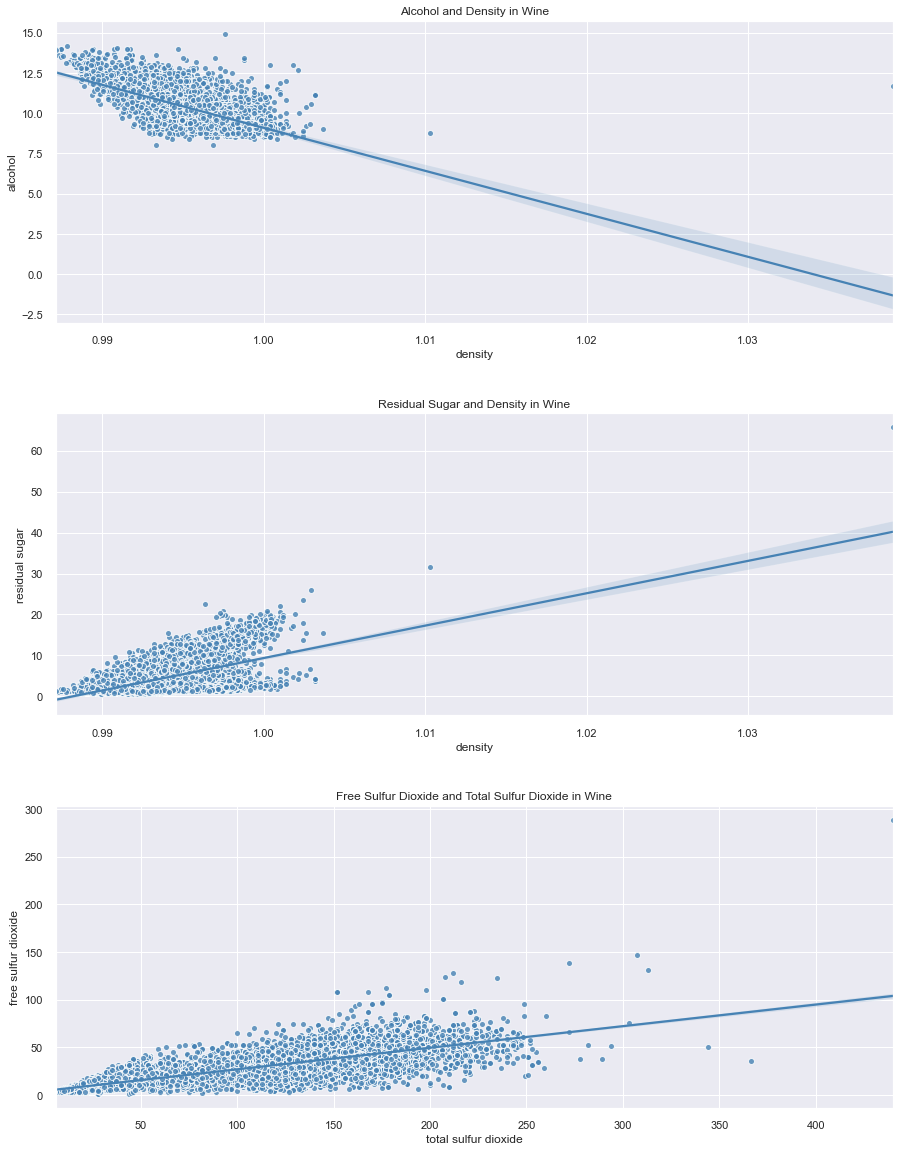

In [13]:
#Creating scatterplots of correlated features
f, axes = plt.subplots(ncols=1, nrows=3)
f.set_size_inches(15,20)
f1=sns.regplot(ax=axes[0], x='density',y='alcohol', data=df_unique, fit_reg=True, scatter_kws={'edgecolor':'w', 'linewidths':1}, color='steelblue').set(title="Alcohol and Density in Wine")
f2=sns.regplot(ax=axes[1], x='density',y='residual sugar', data=df_unique, fit_reg=True, scatter_kws={'edgecolor':'w', 'linewidths':1}, color='steelblue').set(title="Residual Sugar and Density in Wine")
f3=sns.regplot(ax=axes[2], x='total sulfur dioxide',y='free sulfur dioxide', data=df, fit_reg=True, scatter_kws={'edgecolor':'w', 'linewidths':1}, color='steelblue').set(title="Free Sulfur Dioxide and Total Sulfur Dioxide in Wine")
plt.subplots_adjust(wspace=0.3, hspace=0.3)
sns.set(rc={'figure.figsize':(8,18)})
plt.show()

In [14]:
# **********************************************************************************************************************
# PREPROCESSING DATASET
# **********************************************************************************************************************

#Creating a new dataframe 'df_features' without the quality and type
df_features = df_unique.drop(['type', 'type_num', 'quality', 'density', 'total sulfur dioxide'], axis=1)
df_features

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
5               7.4              0.66         0.00             1.8      0.075   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide    pH  sulphates  alcohol  
0                    11.0  3.51       0.56      9.4  
1                    25.0  3.20       0.68      9.8  
2                    15.0  3.26       0.65      9.8  
3                    17.0  3.16       0.58      9.8  
5                    13.0  3.51       0.56      9.4  
...                   ...   ...        ...      ...  
4893                 24.0  3.27       0.50     11.2  
4894                 57.0  3.15       0.46      9.6  
4895                 30.0  2.99       0.46      9.4  
4896                 20.0  3.34       0.38     12.8  
4897                 22.0  3.26       0.32     11.8  

[5320 rows x 9 columns]

In [15]:
#Normalising data in df_clustering and creating a dataframe df_normalised for the normalised data. This is going to be used for clustering.
features = df_features.values 
columns = df_features.columns
scaler = preprocessing.MinMaxScaler()
features_scaled = scaler.fit_transform(features)
df_normalised = pd.DataFrame(features_scaled, columns=columns)

df_normalised

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.297521          0.413333     0.000000        0.019939   0.111296   
1          0.330579          0.533333     0.000000        0.030675   0.147841   
2          0.330579          0.453333     0.024096        0.026074   0.137874   
3          0.611570          0.133333     0.337349        0.019939   0.109635   
4          0.297521          0.386667     0.000000        0.018405   0.109635   
...             ...               ...          ...             ...        ...   
5315       0.198347          0.086667     0.174699        0.015337   0.049834   
5316       0.231405          0.160000     0.216867        0.113497   0.063123   
5317       0.223140          0.106667     0.114458        0.009202   0.053156   
5318       0.140496          0.140000     0.180723        0.007669   0.021595   
5319       0.181818          0.086667     0.228916        0.003067   0.018272   

      free sulfur dioxide        pH  sulphates   alcohol  
0                0.034722  0.612403   0.191011  0.202899  
1                0.083333  0.372093   0.258427  0.260870  
2                0.048611  0.418605   0.241573  0.260870  
3                0.055556  0.341085   0.202247  0.260870  
4                0.041667  0.612403   0.191011  0.202899  
...                   ...       ...        ...       ...  
5315             0.079861  0.426357   0.157303  0.463768  
5316             0.194444  0.333333   0.134831  0.231884  
5317             0.100694  0.209302   0.134831  0.202899  
5318             0.065972  0.480620   0.089888  0.695652  
5319             0.072917  0.418605   0.056180  0.550725  

[5320 rows x 9 columns]

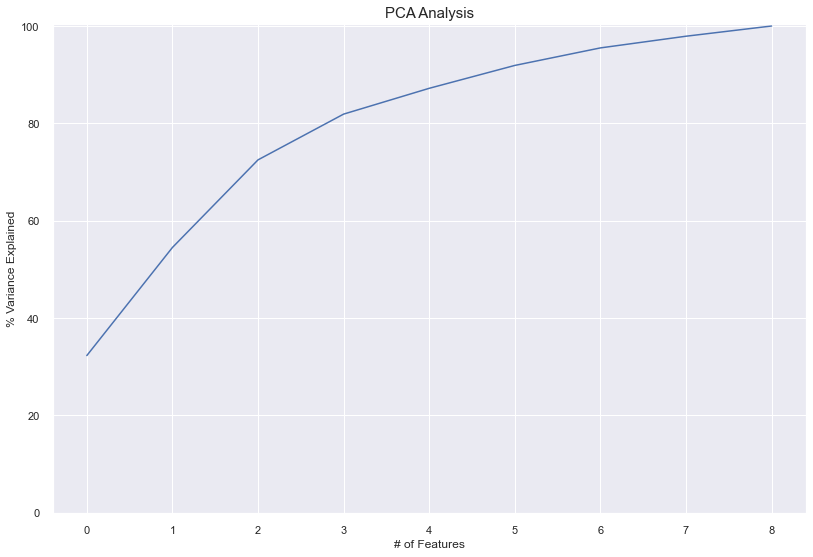

In [16]:
#Plotting variance 
pca = PCA(n_components=9)
pca.fit(df_normalised)
variance = pca.explained_variance_ratio_ 
var=np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(13.5,9))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis',fontsize=15)
plt.ylim(0,100.5)
plt.plot(var)
plt.show()

In [17]:
#Principal component analysis (PCA) to reduce the dimensionality of the dataset to 2. 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_normalised)
df_normalised['PCA1'] = pca_result[:, 0]
df_normalised['PCA2'] = pca_result[:,1]

df_pca = df_normalised[['PCA1', 'PCA2']].copy()

df_pca

PCA1      PCA2
0    -0.111570  0.395295
1    -0.119507  0.296554
2    -0.105033  0.276127
3    -0.160766 -0.101265
4    -0.110583  0.379728
...        ...       ...
5315  0.125017 -0.023395
5316 -0.144632 -0.059546
5317 -0.164232 -0.103908
5318  0.367795 -0.002767
5319  0.213167 -0.079524

[5320 rows x 2 columns]

<Figure size 900x600 with 0 Axes>

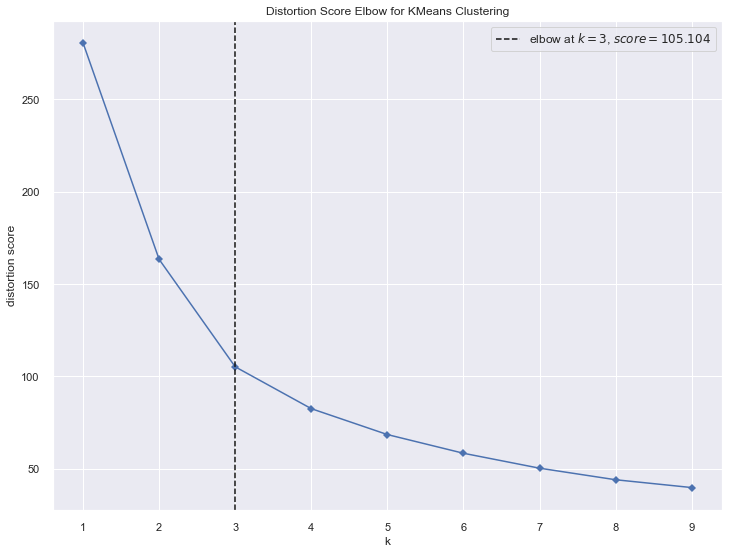

In [18]:
# **********************************************************************************************************************
# KMEANS
# **********************************************************************************************************************

#Elbow method to find the optimal value of number of centroids k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10), timings=False, size=(900, 600))
plt.figure(figsize=(12,9))
visualizer.fit(df_pca)      
visualizer.show()       
optimal_k = visualizer.elbow_value_

#K-means at k at optimal_k and maximum iterations set to 200
k_means =KMeans(init='k-means++', n_clusters=optimal_k, max_iter=200, random_state=0)
k_means.fit(df_pca)
centroids = k_means.cluster_centers_
kmeans_labels = k_means.labels_

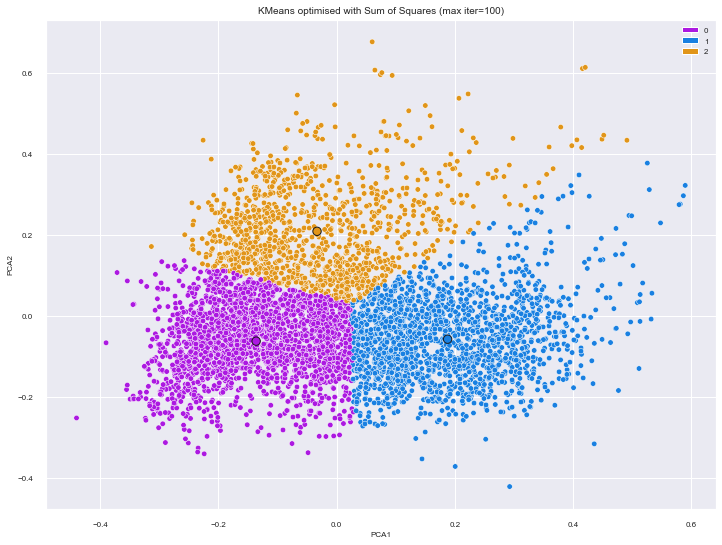

In [19]:
colours = ['#AC19E1', '#1980E1','#E19519']
custom_cmap = colors.ListedColormap(colours)
colours2 = ['#AC19E1', '#1980E1','#E19519','#7cb063','#d16e5a','#d174c1']
custom_cmap2 = colors.ListedColormap(colours2)

#Scatter plot for K-means
plt.figure(figsize=(12,9))
plt.scatter(df_pca.iloc[:,0], df_pca.iloc[:,1], c=k_means.labels_, cmap=custom_cmap, edgecolors='w', linewidths=0.5, s=30)
plt.scatter(centroids[:,0], centroids[:,1], s=70, cmap=custom_cmap, marker='o', edgecolors='k', linewidths=1, c=np.unique(k_means.labels_))
plt.title('KMeans optimised with Sum of Squares (max iter=100)',fontsize=10)
plt.xlabel('PCA1', fontsize=8)
plt.ylabel('PCA2', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

#setting up the legend colors and labels
#get the unique labels
cmap = cm.get_cmap(custom_cmap)
unique_labels = np.unique(k_means.labels_)  
norm = colors.Normalize(vmin=0, vmax=(optimal_k-1))
class_colours = [cmap(norm(x)) for x in unique_labels]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1, fc=class_colours[i]))
plt.legend(recs,unique_labels,loc=1,prop={'size': 8})
plt.show()

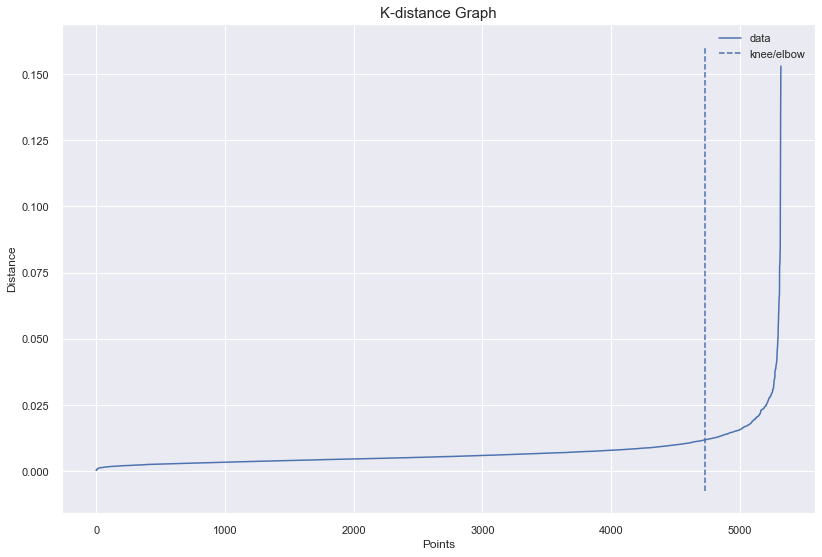

min_samples = 4
n_neighbours = 3
eps = 0.011774379931256455
Silhouette Score: -0.4945980238070905
Number of Clusters: 56


In [20]:
# **********************************************************************************************************************
# DBSCAN
# **********************************************************************************************************************

#DBSCAN Method 1

#Taking [minPts = 2*dim] and [k = 2*dim - 1]. as suggested by Schubert et. al based on previous work by Sander et. al. 
dim = len(df_pca.columns)
minPts = 2 * dim
kneighbours = minPts - 1

#Building K-distance graph to find optimal epsilon value and using kneed to get the exact value
nearest_neighbors = NearestNeighbors(n_neighbors=kneighbours)
neighbors = nearest_neighbors.fit(df_pca)
distances, indices = neighbors.kneighbors(df_pca)
distances = np.sort(distances[:,(kneighbours-1)], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
knee.plot_knee(figsize=[13.5,9])
plt.xlabel("Points")
plt.ylabel("Distance")
plt.title('K-distance Graph',fontsize=15)
optimal_eps = distances[knee.knee]
plt.show()

print('min_samples = ' + str(minPts))
print('n_neighbours = ' + str(kneighbours))
print('eps = ' + str(optimal_eps))

dbscan = DBSCAN(eps=optimal_eps, min_samples=minPts)
dbscan.fit(df_pca)
dbscan_labels = dbscan.labels_

silhouette = silhouette_score(df_pca,dbscan.labels_)
print(str('Silhouette Score: ' + str(silhouette)))

print('Number of Clusters: ' +str(len(np.unique(dbscan_labels))))

In [21]:
#DBSCAN Method 2

#Basing DBSCAN parameters on optimal silhouette score
for i, j in itertools.product(np.arange(0.001,0.05,0.005), range(4,30)):
    #DBSCAN at eps at optimal_eps and min_samples at minPts
    dbscan_sil = DBSCAN(eps=i, min_samples=j)
    dbscan_sil.fit(df_pca)
    dbscan_sil_labels = dbscan_sil.labels_
    if len(np.unique(dbscan_sil_labels)) > 1:
        silhouette = silhouette_score(df_pca,dbscan_sil.labels_)
        print('eps: ' + str(round(i,4)) +' & minPts: ' + str(j) + ', silhouette score: ' + str(silhouette) + ' & clusters: ', len(np.unique(dbscan_sil_labels)))

eps: 0.001 & minPts: 4, silhouette score: -0.3261216525050442 & clusters:  2
eps: 0.006 & minPts: 4, silhouette score: -0.2319111994124169 & clusters:  299
eps: 0.006 & minPts: 5, silhouette score: -0.34314950396496907 & clusters:  212
eps: 0.006 & minPts: 6, silhouette score: -0.48573523160320203 & clusters:  132
eps: 0.006 & minPts: 7, silhouette score: -0.5785607719552606 & clusters:  86
eps: 0.006 & minPts: 8, silhouette score: -0.6350094809943273 & clusters:  50
eps: 0.006 & minPts: 9, silhouette score: -0.6224175196628482 & clusters:  32
eps: 0.006 & minPts: 10, silhouette score: -0.5869563563374497 & clusters:  19
eps: 0.006 & minPts: 11, silhouette score: -0.2955712694697871 & clusters:  7
eps: 0.006 & minPts: 12, silhouette score: -0.27661864889738574 & clusters:  3
eps: 0.006 & minPts: 13, silhouette score: -0.27941612332284455 & clusters:  3
eps: 0.011 & minPts: 4, silhouette score: -0.5172448923138199 & clusters:  65
eps: 0.011 & minPts: 5, silhouette score: -0.521511640177

eps: 0.026 & minPts: 20, silhouette score: 0.10010471348674699 & clusters:  3
eps: 0.026 & minPts: 21, silhouette score: 0.31188267847755374 & clusters:  2
eps: 0.026 & minPts: 22, silhouette score: 0.3106318201588431 & clusters:  2
eps: 0.026 & minPts: 23, silhouette score: 0.2071286064056341 & clusters:  3
eps: 0.026 & minPts: 24, silhouette score: 0.20457468703070322 & clusters:  3
eps: 0.026 & minPts: 25, silhouette score: 0.198465166377949 & clusters:  3
eps: 0.026 & minPts: 26, silhouette score: 0.19818046074680462 & clusters:  3
eps: 0.026 & minPts: 27, silhouette score: 0.19394937775863094 & clusters:  3
eps: 0.026 & minPts: 28, silhouette score: 0.2909667673719303 & clusters:  2
eps: 0.026 & minPts: 29, silhouette score: 0.28806669562177506 & clusters:  2
eps: 0.031 & minPts: 4, silhouette score: 0.2167754720794699 & clusters:  12
eps: 0.031 & minPts: 5, silhouette score: 0.2124803628987732 & clusters:  10
eps: 0.031 & minPts: 6, silhouette score: 0.20753899717171953 & cluster

eps: 0.046 & minPts: 23, silhouette score: 0.42688259706632775 & clusters:  2
eps: 0.046 & minPts: 24, silhouette score: 0.4259179126427945 & clusters:  2
eps: 0.046 & minPts: 25, silhouette score: 0.422678493000904 & clusters:  2
eps: 0.046 & minPts: 26, silhouette score: 0.41982260363286794 & clusters:  2
eps: 0.046 & minPts: 27, silhouette score: 0.4197236895718332 & clusters:  2
eps: 0.046 & minPts: 28, silhouette score: 0.4162958121841283 & clusters:  2
eps: 0.046 & minPts: 29, silhouette score: 0.414656382958219 & clusters:  2


In [22]:
#Optimal silhouette score is 0.4768589816 at eps = 0.046 and min_samples = 9
dbscan2 = DBSCAN(eps=0.046, min_samples=9)
dbscan2.fit(df_pca)
dbscan2_labels = dbscan2.labels_

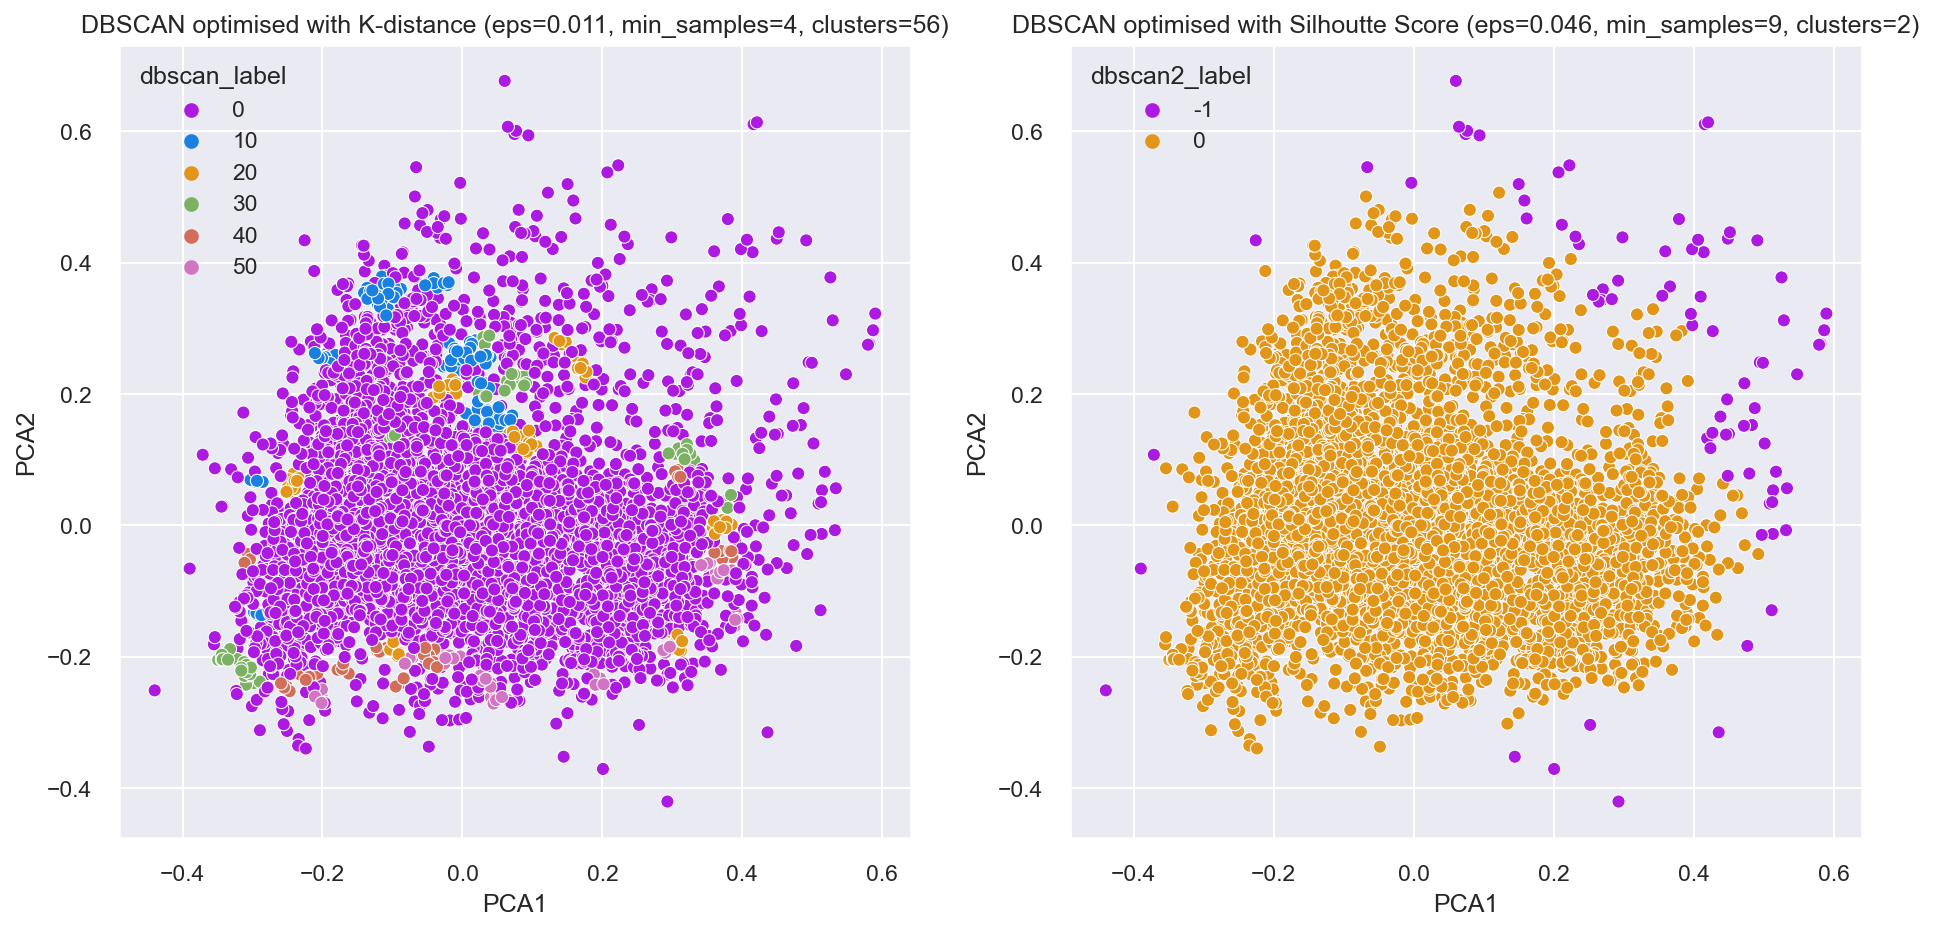

In [23]:
df_pca['dbscan_label'] = dbscan_labels
df_pca['dbscan2_label'] = dbscan2_labels

f, axes = plt.subplots(ncols=2, nrows=1,dpi=150)
f.set_size_inches(15, 7)
dbscan1=sns.scatterplot(ax=axes[0], x='PCA1',y='PCA2', data=df_pca, hue='dbscan_label', palette=custom_cmap2, s=40)
dbscan1.title.set_text('DBSCAN optimised with K-distance (eps=0.011, min_samples=4, clusters=56)')

dbscan2=sns.scatterplot(ax=axes[1], x='PCA1',y='PCA2', data=df_pca, hue='dbscan2_label', palette=custom_cmap, s=40)
dbscan2.title.set_text('DBSCAN optimised with Silhoutte Score (eps=0.046, min_samples=9, clusters=2)')
plt.show()

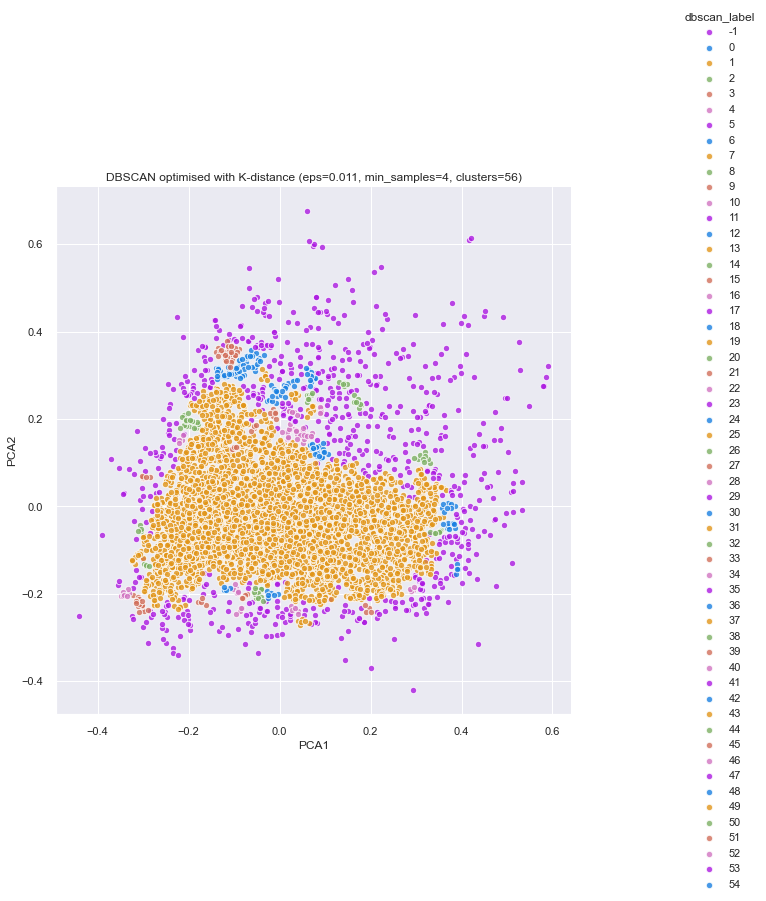

In [24]:
#linear model plot for DBSCAN method 1, since the scatterplot combined multiple clusters into one 
#(e.g. clusters 1-10 into cluster 10)

cmap2= ['#AC19E1','#1980E1','#E19519','#7CB063','#D16E5a','#D174C1']
sns.lmplot(size=8,x='PCA1',y='PCA2', data=df_pca, fit_reg=False, hue='dbscan_label', palette=sns.color_palette(cmap2, n_colors=56),scatter_kws={'edgecolor':'w', 'linewidths':1, 's':40}, legend=False)
plt.title("DBSCAN optimised with K-distance (eps=0.011, min_samples=4, clusters=56)",fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), ncol=1,title='dbscan_label')
plt.show()

In [25]:
# **********************************************************************************************************************
# PLOTTING
# **********************************************************************************************************************

#adding labels to original dataframe to plot scatter plots of features 
df_unique['kmeans_label'] = kmeans_labels
df_unique['dbscan_label'] = dbscan_labels
df_unique['dbscan2_label'] = dbscan2_labels

In [ ]:
#Pairplot for KMeans (k=3,max_iter=100)
cmap1=['#AC19E1', '#1980E1','#E19519']
sns.pairplot(df_unique[df_unique.columns.difference(['dbscan_label','dbscan2_label','type','type_num','quality'])],hue='kmeans_label', palette=cmap1)
sns.set(rc={'figure.figsize':(50,50),'figure.dpi':300})
plt.show()

In [ ]:
#Pairplot for DBSCAN Method 1 (eps and min_samples based on Schubert et. al)
cmap2= ['#AC19E1','#1980E1','#E19519','#7CB063','#D16E5a','#D174C1']
sns.pairplot(df_unique[df_unique.columns.difference(['kmeans_label','dbscan2_label','type','type_num','quality'])],hue='dbscan_label', palette=sns.color_palette(cmap2, n_colors=56))
sns.set(rc={'figure.figsize':(50,50),'figure.dpi':300})
plt.show()

In [ ]:
#Pairplot for DBSCAN Method 2 (eps and min_samples based on Silhoutte Score)
cmap1=['#AC19E1', '#1980E1','#E19519']
sns.pairplot(df_unique[df_unique.columns.difference(['kmeans_label','dbscan_label','type','type_num','quality'])],hue='dbscan2_label', palette=sns.color_palette(cmap1, n_colors=2))
sns.set(rc={'figure.figsize':(50,50),'figure.dpi':300})
plt.show()

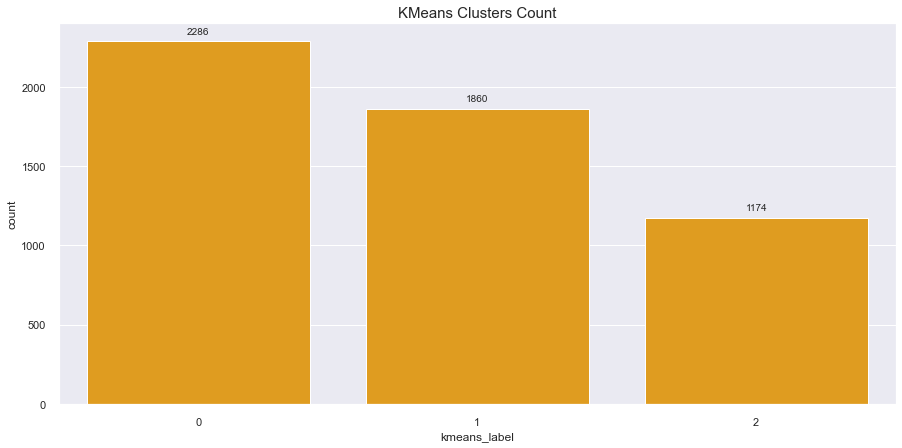

In [29]:
# **********************************************************************************************************************
# ANALYSIS OF RESULTS
# **********************************************************************************************************************

df.to_csv('winequality_clustered.csv', index=False)

#Number of points in each KMeans Cluster
f, axes = plt.subplots(1)
f.set_size_inches(15, 7)    
kmeans_clusters_count = sns.countplot(df_unique['kmeans_label'],color='orange')
df_unique['kmeans_label'].value_counts()
sns.set(rc={'figure.figsize':(5,5)})
for p in kmeans_clusters_count.patches:
    kmeans_clusters_count.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)
plt.title('KMeans Clusters Count',fontsize=15)
plt.show()

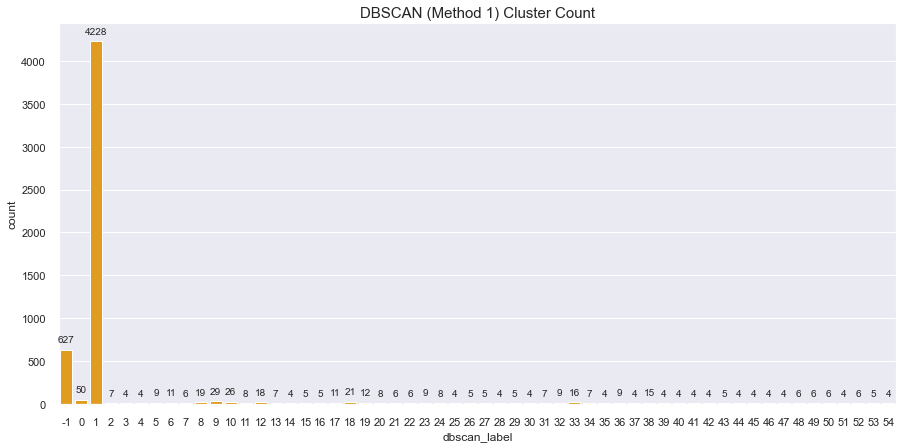

In [30]:
#Number of points in each DBSCAN Cluster for Method 1
f, axes = plt.subplots(1)
f.set_size_inches(15, 7)
dbscan_clusters_count = sns.countplot(df_unique['dbscan_label'],color='orange')
df_unique['dbscan_label'].value_counts()
sns.set(rc={'figure.figsize':(15,7.5)})
for p in dbscan_clusters_count.patches:
       dbscan_clusters_count.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)
plt.title('DBSCAN (Method 1) Cluster Count',fontsize=15)
plt.show()

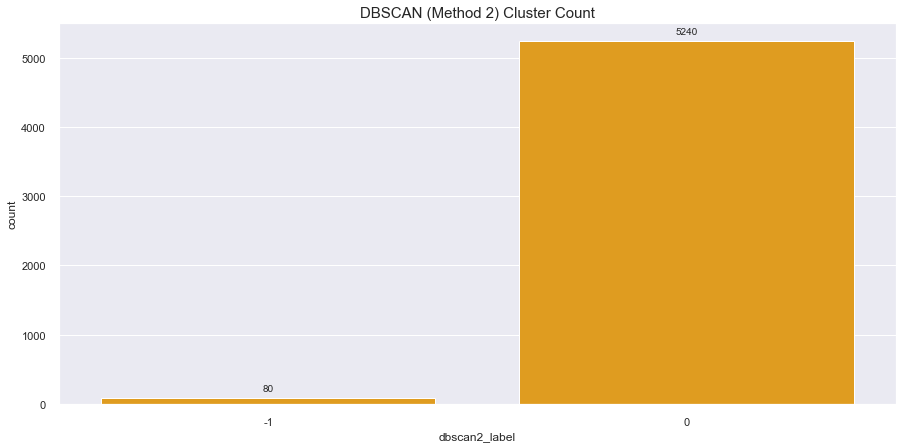

In [31]:
#Number of points in each DBSCAN Cluster for Method 2
f, axes = plt.subplots(1)
f.set_size_inches(15, 7)
dbscan2_clusters_count = sns.countplot(df_unique['dbscan2_label'],color='orange')
df_unique['dbscan2_label'].value_counts()
sns.set(rc={'figure.figsize':(7,7.5)})
for p in dbscan2_clusters_count.patches:
       dbscan2_clusters_count.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)
plt.title('DBSCAN (Method 2) Cluster Count',fontsize=15)
plt.show()

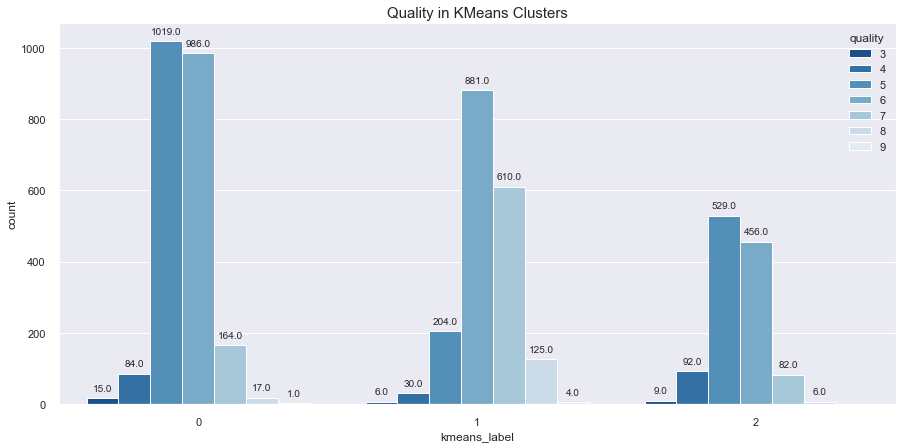

In [32]:
#In the remaining section, only data related to KMeans clusters is considered, given that DBSCAN did not produce good results
#This is likely due to the fact that the data set is highly dense, whereas DBSCAN clusters on the basis of high density separated by points of lower density

#Distribution of Quality within the KMeans Cluster
f, axes = plt.subplots(1)
f.set_size_inches(15, 7)
kmeans_quality_count = sns.countplot(x='kmeans_label',hue='quality',data=df_unique,palette='Blues_r')
for p in kmeans_quality_count.patches:
       kmeans_quality_count.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)
plt.legend(loc='upper right', ncol=1,title="quality")
sns.set(rc={'figure.figsize':(12,10)})
plt.title('Quality in KMeans Clusters',fontsize=15)
plt.show()

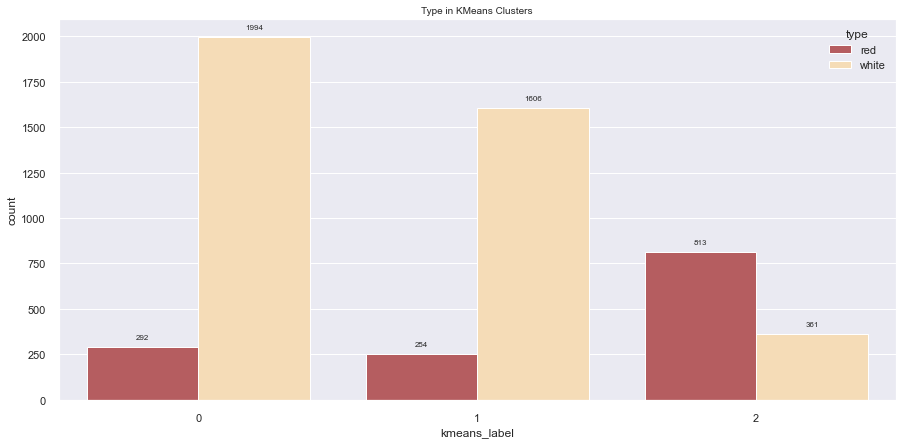

In [33]:
#Distribution of Type within the KMeans Cluster
#It can be observed that clusters 0 and 1 contain mostly type=white, while cluster 2 contains mostly type=red

f, axes = plt.subplots(1)
f.set_size_inches(15, 7)
kmeans_quality_count = sns.countplot(x='kmeans_label', hue='type', data=df_unique,palette={'red':'r', 'white':'navajowhite'})
for p in kmeans_quality_count.patches:
       kmeans_quality_count.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=8)
sns.set(rc={'figure.figsize':(6,5)})
plt.title('Type in KMeans Clusters',fontsize=10)
plt.show()

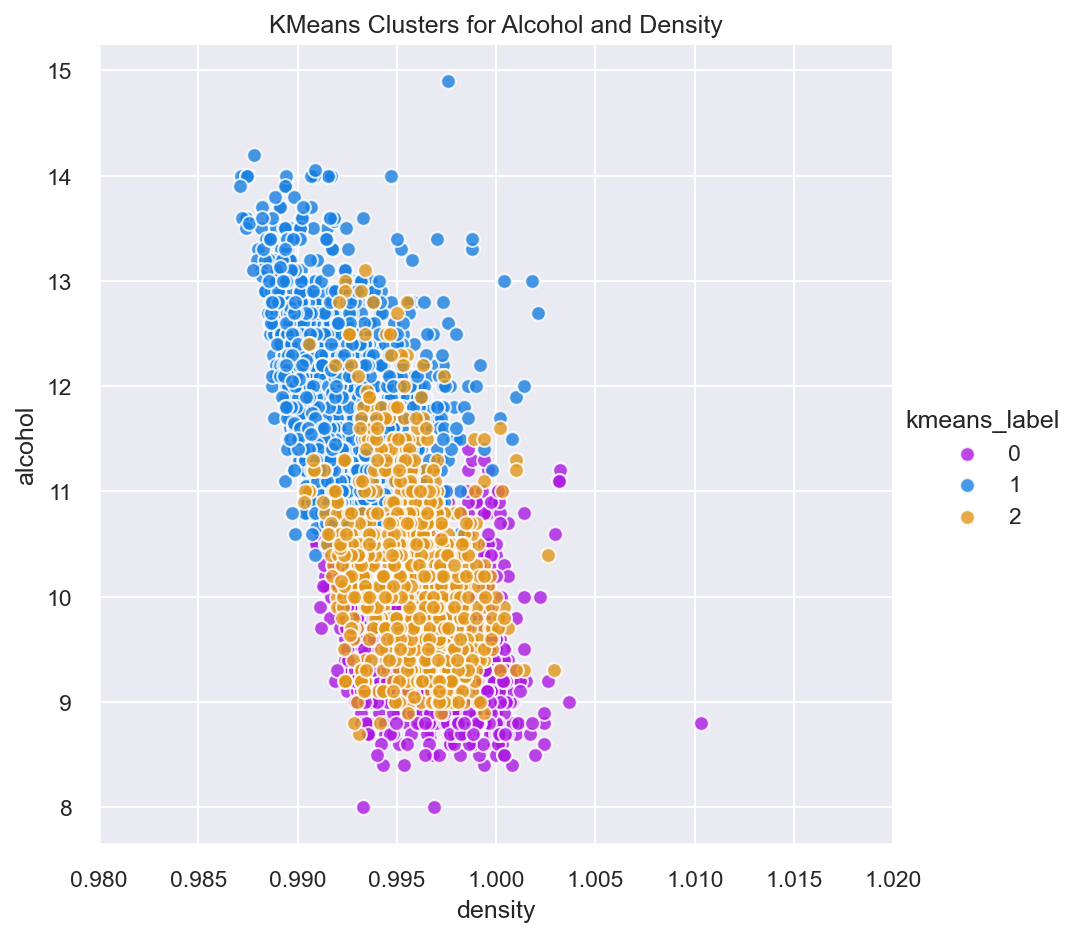

In [37]:
#Further analysis to understand KMeans clusters. It can be noted that while both 0 and 1 contain wines of type=white, cluster 1 contains higher levels of alcohol

sns.lmplot(size=6, x='density',y='alcohol', data=df_unique, fit_reg=False, hue='kmeans_label', palette=sns.color_palette(cmap2, n_colors=56),scatter_kws={'edgecolor':'w', 'linewidths':1, 's':50})
sns.set(rc={'figure.dpi':150})
plt.title("KMeans Clusters for Alcohol and Density",fontsize=12)
plt.xlim(0.98,1.02)
plt.show()

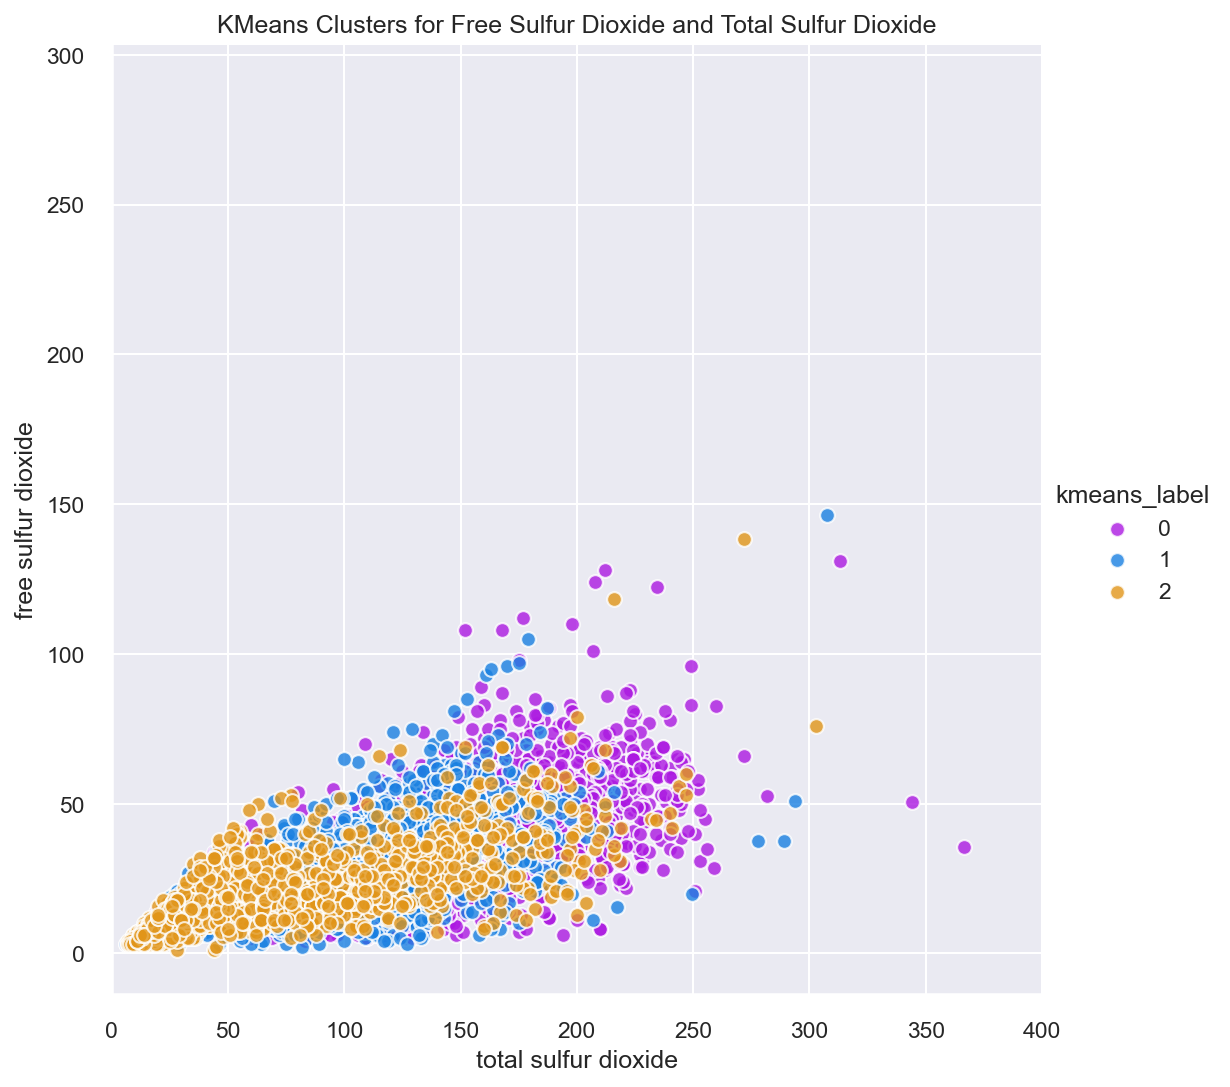

In [35]:
sns.lmplot(size=7, x='total sulfur dioxide',y='free sulfur dioxide', data=df_unique, fit_reg=False, hue='kmeans_label', palette=sns.color_palette(cmap2, n_colors=56),scatter_kws={'edgecolor':'w', 'linewidths':1, 's':50})
plt.title("KMeans Clusters for Free Sulfur Dioxide and Total Sulfur Dioxide",fontsize=12)
plt.xlim(0,400)
plt.show()

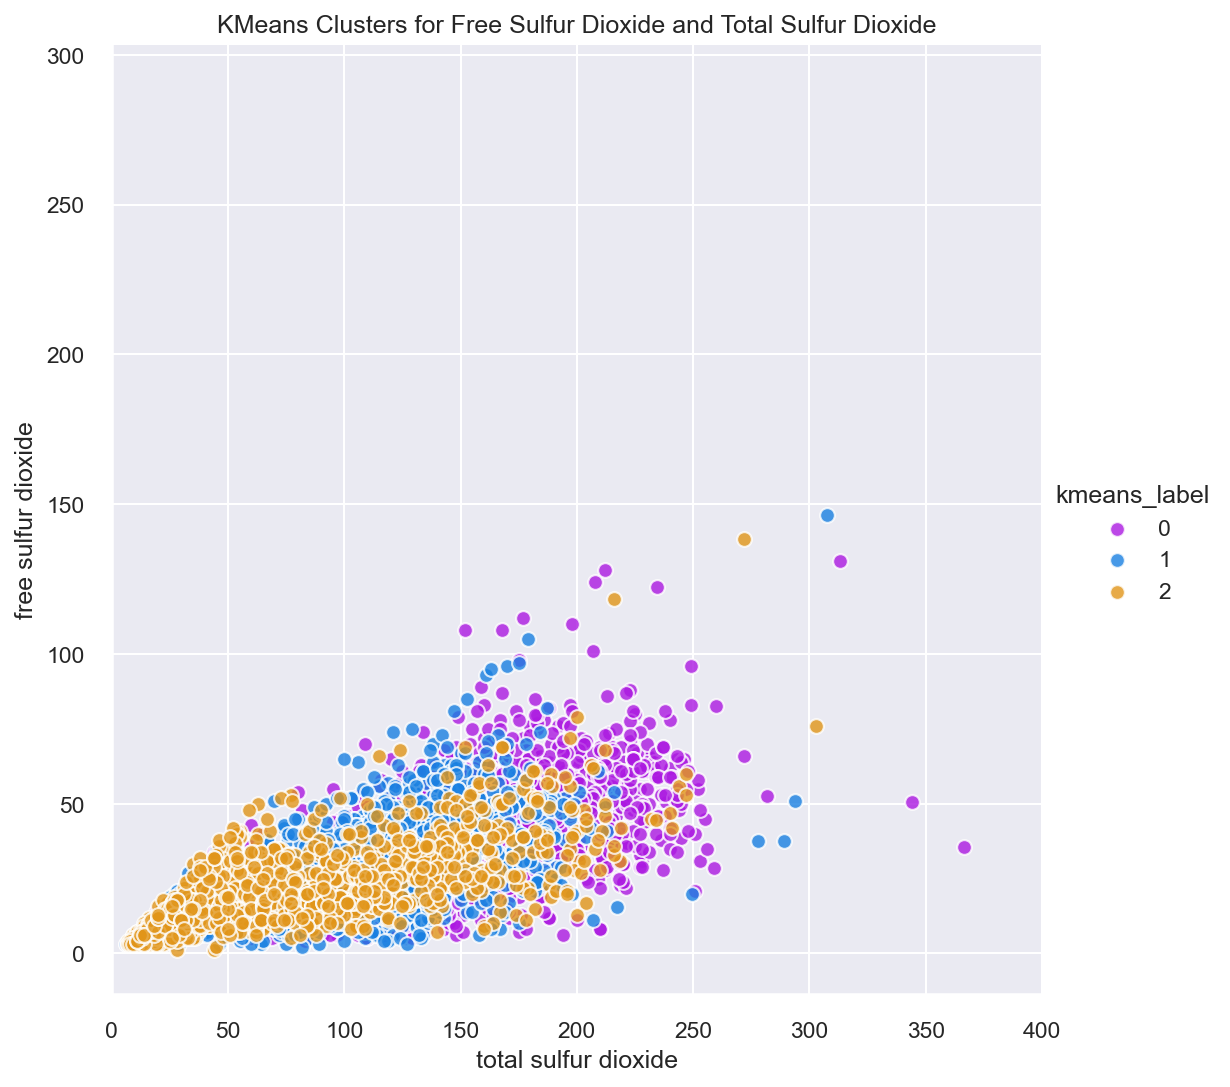

In [36]:
sns.lmplot(size=7, x='total sulfur dioxide',y='free sulfur dioxide', data=df_unique, fit_reg=False, hue='kmeans_label', palette=sns.color_palette(cmap2, n_colors=56),scatter_kws={'edgecolor':'w', 'linewidths':1, 's':50})
plt.title("KMeans Clusters for Free Sulfur Dioxide and Total Sulfur Dioxide",fontsize=12)
plt.xlim(0,400)
plt.show()